# gridded_data_tutorial
## Notebook 3: DayMet
Waterhackweek 2020
Steven Pestana (spestana@uw.edu)
***


## What is DayMet?

</br></br>

<div align="left" style="display:inline-block;float:left;width:50%;">

* Gridded daily data at 1 km resolution
* Spatial: North America, Hawaii, Puerto Rico
* Data is hosted by the [Oak Ridge National Lab DAAC](https://daymet.ornl.gov/)
* Access methods web portal, ulmo, [daymetpy](bluegreen-labs.github.io/daymetpy), OPeNDAP Application Programming Interface (API)

We will be using:

**Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 3**
* [User Guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)
* [Recent article about Daymet](https://earthdata.nasa.gov/learn/articles/daymet-and-daymet-2019-data)
* ...



</div>



<div align="right" style="display:inline-block;float:right;width:50%;">

<img src="https://cdn.earthdata.nasa.gov/conduit/upload/14259/DEM_HorizonFiles_2010stns_crop-resize_continent-only.jpg" style="height:300px;align:center;">

</div>

### How can we access this data? 

using [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) (Open-source Project for a Network Data Access Protocol)

* show how to search and select DayMet data using the OPeNDAP endpoint

https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328

https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml.html

https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml

https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#from dask.distributed import Client
#client = Client(n_workers=2, threads_per_worker=2, memory_limit='500MB')
#client

OPeNDAP endpoints for DayMet:

what data can we get and how do we select it?

In [4]:
ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")

What did we just open with xarray? Look at the dataset's structure and metadata:

We have *Dimensions* of **time**, **x**, and **y**; *Coordinates* of **time**, **x**, **y**, **lat**, and **lon**.



In [5]:
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Look at a single data variable and its metadata:

In [6]:
ds.prcp

<xarray.DataArray 'prcp' (time: 14600, y: 8075, x: 7814)>
[2108528656 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4560250.0 -4559250.0 ... 3251750.0 3252750.0
  * y        (y) float32 4984000.0 4983000.0 4982000.0 ... -3089000.0 -3090000.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

In [7]:
# yay! we now know what the data structure is and what the metadata tells us

Plot a single day of data, this is a really big area so will take some time to plot

using isel to select by index on the time dimension

In [8]:
wa = ds.isel(x=slice(2800,3100),y=slice(4100,4400))

Select precip for December 2019

In [9]:
wa_precip_dec2019 = wa.prcp.sel(time='2019-12')

In [10]:
wa_precip_dec2019

<xarray.DataArray 'prcp' (time: 31, y: 300, x: 300)>
[2790000 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1760250.0 -1759250.0 ... -1462250.0 -1461250.0
  * y        (y) float32 884000.0 883000.0 882000.0 ... 586000.0 585000.0
  * time     (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

Compute the cumulative precipitation for this month

In [11]:
wa_cumulative_precip_dec2019 = wa_precip_dec2019.sum('time')

In [12]:
wa_cumulative_precip_dec2019

<xarray.DataArray 'prcp' (y: 300, x: 300)>
array([[  0.,   0.,   0., ..., 206., 203., 201.],
       [  0.,   0.,   0., ..., 208., 203., 204.],
       [  0.,   0.,   0., ..., 212., 205., 202.],
       ...,
       [  0.,   0.,   0., ...,  19.,  19.,  19.],
       [  0.,   0.,   0., ...,  18.,  19.,  19.],
       [  0.,   0.,   0., ...,  18.,  18.,  19.]], dtype=float32)
Coordinates:
  * x        (x) float32 -1760250.0 -1759250.0 ... -1462250.0 -1461250.0
  * y        (y) float32 884000.0 883000.0 882000.0 ... 586000.0 585000.0
    lat      (y, x) float32 48.310127 48.31292 48.315712 ... 46.350025 46.352272
    lon      (y, x) float32 -125.17524 -125.16179 ... -120.09101 -120.0778

Plot a map of December cumulative precipitation for western Washington.

Text(0.5, 1.0, 'December 2019, Cumulative Precipitation')

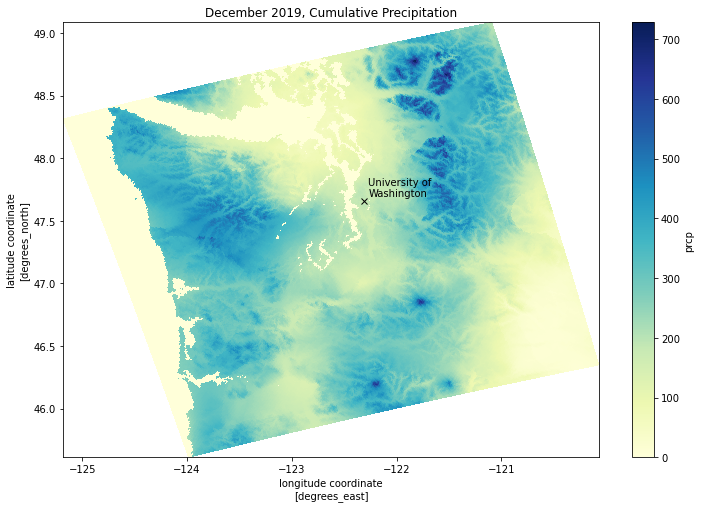

In [13]:
wa_cumulative_precip_dec2019.plot(x='lon', y='lat', figsize=(12, 8), cmap='YlGnBu')

uw_lon = -122.308056
uw_lat = 47.654167

plt.plot(uw_lon, uw_lat, 'kx')
plt.text(uw_lon+0.04, uw_lat+0.04, 'University of\nWashington')

plt.title('December 2019, Cumulative Precipitation')

Plot mean precip across western washington for December 2019

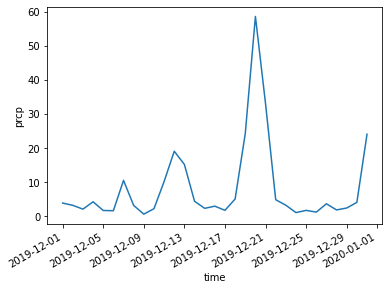

In [30]:
wa_precip_dec2019.mean(['x', 'y']).plot()

### Data selecting/slicing/indexing methods


* define some lat/lon bounding boxes
* define some time bounds


To select a smaller area to work with, we can use the [*xarray.Dataset.isel*](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.isel.html) method on the **time**, **x**, and **y** dimensions.

Try making some plots with this data now showing xarray plotting

In [11]:
# yay! we made some plots

Select SWE for water year 2019 at one grid cell in the dataset.

In [12]:
#uw_precip = wa.prcp.where( (wa.lat==uw_lat) & (wa.lon==uw_lon))

In [13]:
uw_precip = wa.prcp.isel(x=100, y=200)

In [ ]:
uw_precip

In [ ]:
#uw_precip.plot(figsize=(12, 8))


---
---


Next section we'll try to answer our **research question**

---

Work in progress

### Reproject with rioxarray

DayMet is provided in a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection), but we would like to reproject this 

In [ ]:
import xarray as xr
import rioxarray
from pyproj import CRS

ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")

# DayMet crs information is in: ds.lambert_conformal_conic
cc = CRS.from_cf(ds.lambert_conformal_conic.attrs)

ds.rio.write_crs(cc.to_string(), inplace=True)

ds.rio.reproject("EPSG:4326")

In [ ]:
ds = ds.isel(time=0, x=slice(2700,3500), y=slice(4000,4600))

In [ ]:
ds

This gives us all the information we need to define the source projection information using a Proj.4 string.

Note that the semi_major_axis, inverse_flattening, and longitude_of_prime_meridian correspond to the [WGS84 Ellipsoid](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84).


https://gis.stackexchange.com/questions/345650/how-do-i-add-projection-to-this-netcdf-file-satellite/345697#345697

In [ ]:
# Destination coordinate reference system, Proj.4 string
dst_crs = "+proj=longlat +datum=WGS84 +no_defs"



In [ ]:
from pyproj import CRS

cc = CRS.from_cf(ds.lambert_conformal_conic.attrs)

In [ ]:
cc

In [ ]:
# https://github.com/corteva/rioxarray/issues/47

ds_reproject = ds.rio.set_spatial_dims('x', 'y', inplace=True) \
                 .rio.write_crs(cc.to_string(), inplace=True)

In [ ]:
ds_reproject.rio.crs